In [1]:
import numpy as np
import TransportMaps as TM
from TransportMaps.Distributions.Examples.RailwayVehicleDynamics import Coradia175 as C175
from TransportMaps.Algorithms import SequentialInference as ALGSI
import TransportMaps.Distributions as DIST
import TransportMaps.Diagnostics as DIAG
import TransportMaps.Maps as MAPS
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rcParams['font.size'] = 15

# Coradia 175 vehicle

In [2]:
v = 42.5
nsteps = 100
observables=[C175.Ybdot, C175.Pb, C175.Ycdot]
vehicle = C175.Coradia175Vehicle(v, observables=observables)

In [3]:
dofs_idxs = [0, 4, 8, 12, 2, 6, 10]
dofs_names = [r"$Y_{w_1}$", r"$Y_{w_2}$", r"$Y_{b}$", r"$Y_{c}$", r"$\Psi_{w_1}$", r"$\Psi_{w_2}$", r"$\Psi_{b}$"]
def plot_dynamic(T,Z,i,name):
    plt.subplot(2,4,i+1); plt.plot(T,Z); plt.ylabel(name); plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0));
def plot_dynamics(T,Z):
    plt.figure(figsize=(15,7))
    for i, (idx,name) in enumerate(zip(dofs_idxs, dofs_names)):
        plot_dynamic(T,Z[:,idx],i,name)
    plt.tight_layout()
# obs_names = [r"$\ddot{Y}_{w_1}$", r"$\ddot{Y}_{w_2}$", r"$\ddot{Y}_{b}$", r"$\ddot{Y}_{c}$", r"$\ddot{\Psi}_{b}$"]
# obs_pos = [1, 2, 3, 4, 7]
obs_names = [r"$\ddot{Y}_{b}$", r"$\dot{\Psi}_{b}$", r"$\ddot{Y}_{c}$",]
obs_pos = [3, 7, 4]
def plot_data(T,Y):
    plt.figure(figsize=(15,7))
    yy = np.asarray(Y)
    for i, (pos,name) in enumerate(zip(obs_pos,obs_names)):
        plt.subplot(2,4,pos); 
        plt.plot(T,yy[:,i],'.'); 
        plt.ylabel(name);
        plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0));
    plt.tight_layout()

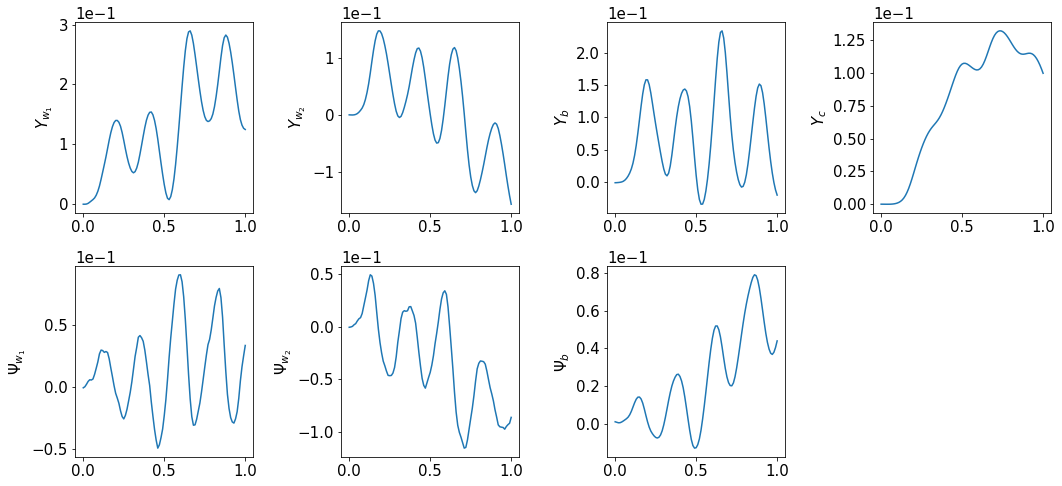

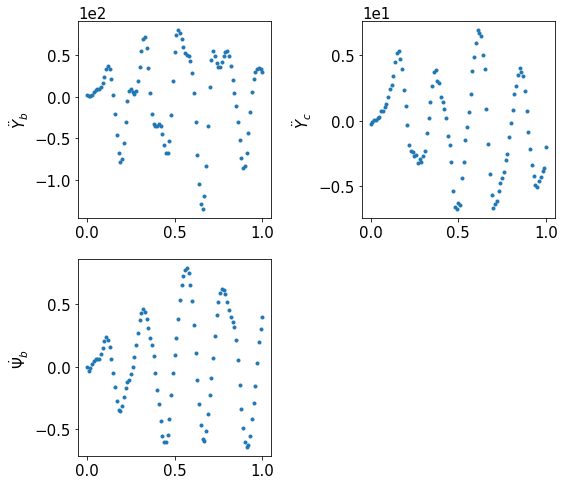

In [4]:
T,Z,Y = C175.generate_data(nsteps, vehicle)
plot_dynamics(T,Z); plot_data(T,Y)

## Kalman filter

In [5]:
par_name_list = []
par_val_list = np.zeros(0)
pi_prior = C175.StateSpacePrior(vehicle, par_name_list, par_val_list)
pi_trans = C175.StateSpaceTransition(vehicle, par_name_list, par_val_list)
FLT = ALGSI.LinearFilter()
for n in range(nsteps+1):
    # Define log-likelihood
    if Y[n] is None: # Missing data
        ll = None
    else: 
        ll = C175.StateSpaceLogLikelihood(Y[n], vehicle, par_name_list, par_val_list)
    # Define transition / prior
    if n > 0: 
        pin = pi_trans
    else:
        pin = pi_prior
    # Assimilation
    FLT.assimilate(pin, ll)

In [6]:
def plot_dynamic_vs_track(T,Z,M,C,i,name):
    plt.subplot(2,4,i+1); 
    plt.plot(T,Z); 
    plt.plot(T,M,'k-');
    conf = 1.96 * np.sqrt(C)
    plt.fill_between(T,M-conf,M+conf,color='r',alpha=0.3)
    plt.ylabel(name); 
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0));
def plot_dynamics_vs_tracks(T,Z,M,C):
    plt.figure(figsize=(15,7))
    for i, (idx,name) in enumerate(zip(dofs_idxs, dofs_names)):
        mean = [m[idx] for m in M]
        var = [cov[idx,idx] for cov in C]
        plot_dynamic_vs_track(T,Z[:,idx],mean,var,i,name)
    plt.tight_layout()

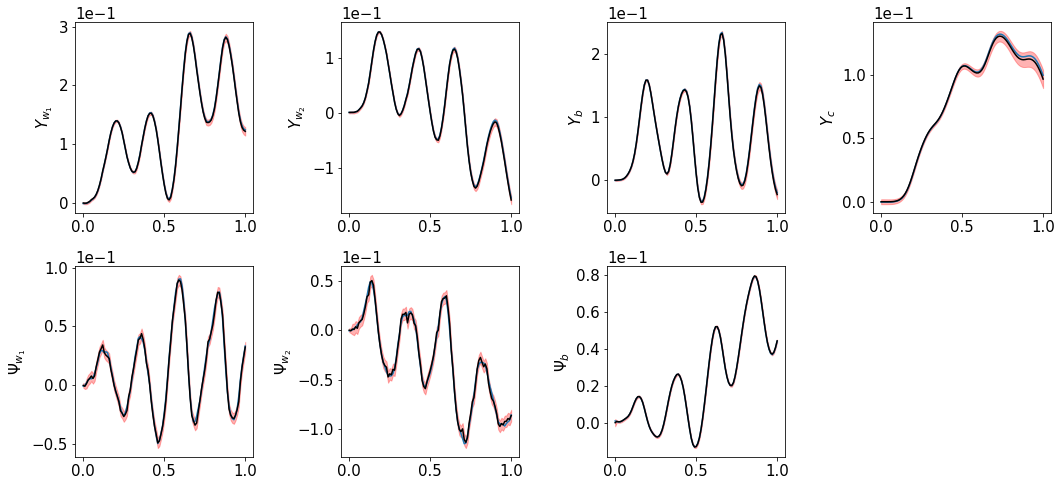

In [7]:
mean_list = FLT.filtering_mean_list
cov_list = FLT.filtering_covariance_list
plot_dynamics_vs_tracks(T,Z,mean_list,cov_list)

## Parameters estimation

### 1D Parameter estimation

In [8]:
par_name_list = ['L_Ky']
pi = C175.ParametersPosterior(Y, vehicle, par_name_list)

In [9]:
P = MAPS.LinearTransportMap(pi.prior.mu,pi.prior.sampling_mat)
pull_P_pi = DIST.PullBackTransportMapDistribution(P, pi)

In [10]:
lap = TM.laplace_approximation(pull_P_pi, tol=1e-5, ders=1, fungrad=True)
L = MAPS.LinearTransportMap.build_from_Gaussian(lap)
pull_LP_pi = DIST.PullBackTransportMapDistribution(L, pull_P_pi)

In [11]:
order = 1
T = TM.Default_IsotropicIntegratedSquaredTriangularTransportMap(
    1, order, 'total')
rho = DIST.StandardNormalDistribution(pi.dim)
push_rho = DIST.PushForwardTransportMapDistribution(T, rho)

In [12]:
import logging
qtype = 3           # Gauss quadrature
qparams = [4] * 1   # Quadrature order
reg = None          # No regularization
tol = 1e-3          # Optimization tolerance
ders = 1            # Use gradient and Hessian
TM.setLogLevel(logging.DEBUG)
log = push_rho.minimize_kl_divergence(
    pull_LP_pi, qtype=qtype, qparams=qparams, regularization=reg,
    tol=tol, ders=ders, fungrad=True)

2017-07-05 12:45:37 DEBUG: TM.IntegratedSquaredTriangularTransportMap: minimize_kl_divergence(): Precomputation started
2017-07-05 12:45:37 DEBUG: TM.IntegratedSquaredTriangularTransportMap: minimize_kl_divergence(): Precomputation ended
2017-07-05 12:45:57 DEBUG: TM.IntegratedSquaredTriangularTransportMap: KL Obj. Eval. 1 - KL-divergence = -1.1342001415e+02
2017-07-05 12:45:57 DEBUG: TM.IntegratedSquaredTriangularTransportMap: KL Grad_a Obj. Eval. 1 - ||grad_a KLdiv|| = 2.6138988260e-02
2017-07-05 12:46:18 DEBUG: TM.IntegratedSquaredTriangularTransportMap: KL Obj. Eval. 2 - KL-divergence = -1.1342001415e+02
2017-07-05 12:46:18 DEBUG: TM.IntegratedSquaredTriangularTransportMap: KL Grad_a Obj. Eval. 2 - ||grad_a KLdiv|| = 2.6138988260e-02
2017-07-05 12:46:35 DEBUG: TM.IntegratedSquaredTriangularTransportMap: KL Obj. Eval. 3 - KL-divergence = -1.1342049832e+02
2017-07-05 12:46:35 DEBUG: TM.IntegratedSquaredTriangularTransportMap: KL Grad_a Obj. Eval. 3 - ||grad_a KLdiv|| = 3.2471867797e-

Variance diagnostic: 5.441832e-04


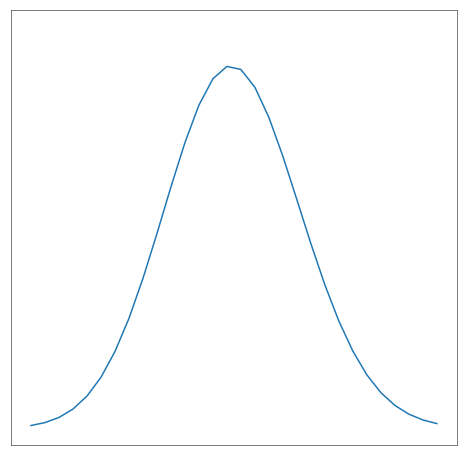

In [13]:
pull_TLP_pi = DIST.PullBackTransportMapDistribution(T, pull_LP_pi)
DIAG.plotAlignedConditionals(pull_TLP_pi, show_flag=False)
var = DIAG.variance_approx_kl(rho, pull_TLP_pi, qtype=3, qparams=[4])
print("Variance diagnostic: %e" % var)